# **MIS581**
Capstone Project
BART
Bay Area Rapid Transit Ridership Study

In [37]:
# standard set of includes for plotting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from datetime import datetime
import requests
import numpy as np
import statistics
import csv
import os
from datetime import timedelta, date
import calendar
import psycopg2
from scipy.stats import chi2_contingency

import matplotlib.pyplot as plt
from statsmodels.graphics import tsaplots

from statsmodels.tsa.seasonal import seasonal_decompose

import BartLibs

print("Current Time =", datetime.now())

Current Time = 2021-04-15 10:15:09.560936


In [38]:
def PGBart(query):
    try:
        query_results = []
        conn = psycopg2.connect(host="10.0.0.206", port=5432,
                                database="bartridership",
                                user="postgres",
                                password="minden12k")
        cur = conn.cursor()
        cur.execute(query)
        query_results = cur.fetchall()
        # Close the cursor and connection to so the server can allocate
        # bandwidth to other requests
        cur.close()
        conn.close()
    except (Exception, psycopg2.Error) as e:
        print("Error in running the query: {}".format(str(e)))
    finally:
        return query_results

def PGBartLocal(query):
    try:
        query_results = []
        conn = psycopg2.connect(host="localhost", port=5432,
                                database="bartridership",
                                user="postgres",
                                password="minden12k")
        cur = conn.cursor()
        cur.execute(query)
        query_results = cur.fetchall()
        # Close the cursor and connection to so the server can allocate
        # bandwidth to other requests
        cur.close()
        conn.close()
    except (Exception, psycopg2.Error) as e:
        print("Error in running the query: {}".format(str(e)))
    finally:
        return query_results


def GetAveragedWeekdayRidersToDest(dest, hour, years):
    global smoothData, scal
    query = """
                
        select avg(cast(riders as double precision)), dest, 
            extract(DOW from depart_date) as dow,
            extract(WEEK from depart_date) as week
        from hourlystationqueue
        where
            extract(ISODOW from depart_date) in (1,2,3,4,5)
        AND
            dest = '{0}'
        and
            depart_hour = {1}
        and 
            extract(MONTH from depart_date) in (1,2,3,4,5,6,7,8,9,10,11,12)
        and
            extract(YEAR from depart_date) in {2}
        group by dest,  extract(WEEK from depart_date), extract(DOW from depart_date)
                
    """.format(dest, hour, years)
    dat = PGBartLocal(query)
    plotdata = list(map(lambda x: x[0], dat))
    return plotdata


def GetAverageDailyDestFrom(source, hour, year):
    global smoothData, scal
    query = """
                                
        select AVG(riders) as riders, source, dest
        from hourlystationqueue
        where
            extract(ISODOW from depart_date) in (1,2,3,4,5)
        AND
            source = '{0}'
        AND 
            depart_hour = {1}
        and 
            extract(YEAR from depart_date) = {2}
        group by source, dest
                
    """.format(source, hour, year)

    dat = PGBartLocal(query)
    plotdata = list(map(lambda x: x, dat))
    return plotdata

In [39]:
def Decomposition(data, per):

    decomposition = seasonal_decompose(data, model="additive", period=per)
    fig = decomposition.plot()
    plt.show()

def ACF(data, lags):
    # Display the autocorrelation plot of your time series
    fig = tsaplots.plot_acf(data, lags=lags)
    plt.show()
    # Display the partial autocorrelation plot of your time series
    fig = tsaplots.plot_pacf(data, lags=lags)
    plt.show()

def SumSquares(ft):
    try:
        r =  np.sqrt(  np.square(ft.real) + np.square(ft.imag)  )
    except(Exception) as e:
        print("Exception: ", e)

    return r

def smoothTriangle(data, degree):
    triangle=np.concatenate((np.arange(degree + 1), np.arange(degree)[::-1])) # up then down
    smoothed=[]

    for i in range(degree, len(data) - degree * 2):
        point=data[i:i + len(triangle)] * triangle
        smoothed.append(np.sum(point)/np.sum(triangle))
    # Handle boundaries
    smoothed=[smoothed[0]]*int(degree + degree/2) + smoothed
    while len(smoothed) < len(data):
        smoothed.append(smoothed[-1])
    return smoothed

def Smooth_1StandardDeviation(dataSet):
    returnData = []
    sdv = statistics.stdev(dataSet)
    mn = statistics.mean(dataSet)
    Maxthreshold = mn + (2.0 * sdv)
    Minthreshold = mn - (2.0 * sdv)
    for d in range(0, len(dataSet)):
        if (dataSet[d] > Maxthreshold ):
            print(d, ' : ' ,dataSet[d], mn+sdv)
            returnData.append(mn + sdv)
        elif (dataSet[d] < Minthreshold ):
            print(d, ' : ' ,dataSet[d], mn-sdv)
            returnData.append(mn - sdv)
        else:
            returnData.append(dataSet[d])
    return returnData


def CalcProp(dataArray):
    tot: Decimal = 0.0
    for d in dataArray:
        tot = tot+float(d)
    propList = list(map(lambda x: float( (float(x)/tot) )*100.0, dataArray))
    return propList

def ChiSqTest(d1,d2):
    rejectHO = False
    data = [d1, d2]
    stat, p, dof, expected = chi2_contingency(data)

    # interpret p-value
    alpha = 0.05
    if p <= alpha:
        rejectHO = True
    return rejectHO, p

def ChiSqTestExp():
    # defining the table
    data = [[50000, 30000, 20000,40000,25000], [50000, 30000, 20000,38000,22000]]
    data = [[10000, 900], [20000, 2100]]
    stat, p, dof, expected = chi2_contingency(data)

    d1 = list(map(lambda x: x/1000, data[0]))
    d2 = list(map(lambda x: x/1000, data[1]))

    data = [d1, d2]
    stat, p, dof, expected = chi2_contingency(data)

    d1 = CalcProp(data[0])
    d2 = CalcProp(data[1])
    data = [d1, d2]
    stat, p, dof, expected = chi2_contingency(data)

    # interpret p-value
    alpha = 0.05
    print("p value is " + str(p))
    if p <= alpha:
        print('Dependent (reject H0)')
    else:
        print('Independent (H0 holds true)')
    return p

def RemoveSmallStationsPercent(per, l1, l2):
    try:
        propL1 = CalcProp(list(map(lambda x: x[0], l1)))
        propL2 = CalcProp(list(map(lambda x: x[0], l2)))
        l1p = []
        l2p = []
        for index, value in enumerate(propL1):
            if propL1[index] > per and propL2[index] > per:
                l1p.append(l1[index])
                l2p.append(l2[index])

    except(Exception) as e:
        print(e)

    return l1p, l2p

def RemoveSmallStations(per, l1, l2):
    try:
        dataL1 = (list(map(lambda x: x[0], l1)))
        dataL2 = (list(map(lambda x: x[0], l2)))
        l1p = []
        l2p = []
        for index, value in enumerate(dataL1):
            if dataL1[index] > per and dataL2[index] > per:
                l1p.append(l1[index])
                l2p.append(l2[index])

    except(Exception) as e:
        print(e)

    return l1p, l2p

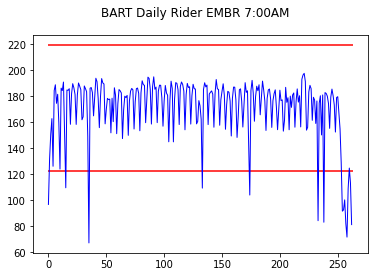

0  :  96.86301369863014 146.90037704947588
15  :  109.64285714285714 146.90037704947588
35  :  67.31901840490798 146.90037704947588
133  :  109.39837398373983 146.90037704947588
174  :  104.08333333333333 146.90037704947588
233  :  84.38414634146342 146.90037704947588
238  :  83.21052631578948 146.90037704947588
254  :  91.70068027210884 146.90037704947588
255  :  92.66216216216216 146.90037704947588
256  :  100.36134453781513 146.90037704947588
257  :  82.07482993197279 146.90037704947588
258  :  71.78378378378379 146.90037704947588
259  :  109.08333333333333 146.90037704947588
261  :  113.375 146.90037704947588
262  :  81.375 146.90037704947588


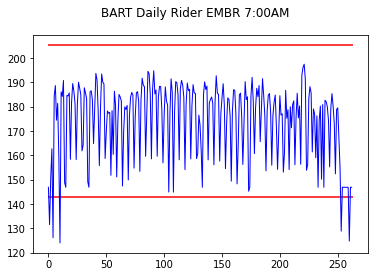

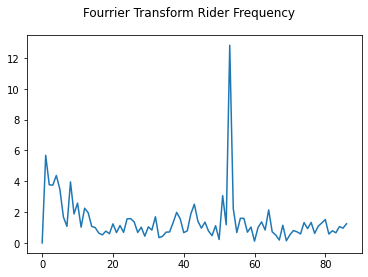

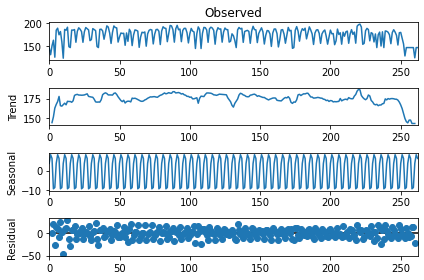

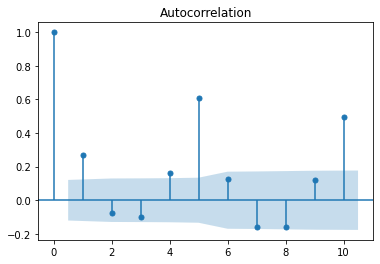

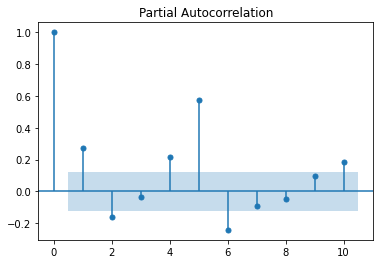

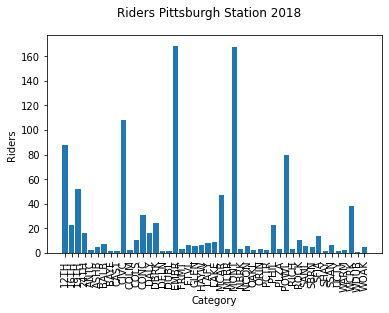

Reject HO:  True  p-value : 0.9997091444669697
name 'mticker' is not defined
Completed


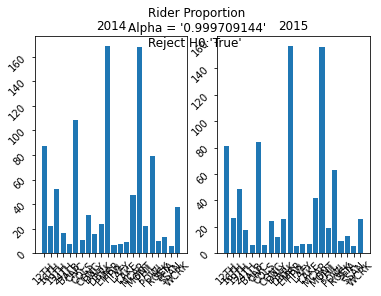

In [40]:
def RunBARTTimeSeries():
    plotdata = GetAveragedWeekdayRidersToDest('EMBR', 7, '(2013,2014,2015,2016,2017,2018,2019)')

    PlotTimeSeriesWithLimitBars(plotdata)

    smoothData = BartLibs.Smooth_1StandardDeviation(plotdata)
    PlotTimeSeriesWithLimitBars(smoothData)

    PlotTimeSeriesFFT(smoothData)

    BartLibs.Decomposition(smoothData, 5)
    BartLibs.ACF(smoothData, 10)


def PlotTimeSeriesFFT(smoothData):
    smoothMean = statistics.mean(smoothData)
    smoothDataZeroed = list(map(lambda x: x - smoothMean, smoothData))
    ft = np.fft.fft(smoothDataZeroed)
    realAmplitudes = list(map(lambda x: BartLibs.SumSquares(x), ft))
    realAmpsLen = len(realAmplitudes)
    fftScale = 2.0 / (realAmpsLen)
    realAmplitudesScaled = list(map(lambda x: fftScale * x, realAmplitudes))
    plt.plot(realAmplitudesScaled[:int(realAmpsLen / 3.0)])
    plt.suptitle("Fourrier Transform Rider Frequency")
    plt.show()


def PlotTimeSeriesWithLimitBars(plotdata):
    rawLen = len(plotdata)
    x = list(range(rawLen))
    plt.plot(x, plotdata,
             color='blue',
             linewidth=1
             )
    sdv = statistics.stdev(plotdata)
    mn = statistics.mean(plotdata)
    Maxthreshold = mn + (2.0 * sdv)
    Minthreshold = mn - (2.0 * sdv)
    plt.hlines(Maxthreshold, 0, rawLen, colors="red")
    plt.hlines(Minthreshold, 0, rawLen, colors="red")
    plt.suptitle("BART Daily Rider EMBR 7:00AM")
    plt.show()


def CosFFT():
    N = 512
    T = 1/N
    F = int(20)
    P = int(np.round(N/F))
    print("Frequency: ", F)
    print("Period: ",P)
    x = np.linspace(0.0, N, N, endpoint=False)
    y = 10*np.sin(F * 2.0*np.pi*(x/N)) #+ 5*np.sin(10 * 2.0*np.pi*x)
    y = list(map(lambda x: x - statistics.mean(y), y))
    plt.plot(x, y,
             color='blue',
             linewidth=1
             )
    plt.show()

    ft = np.fft.fft(y)
    rt = []
    rt = list(map(lambda x: BartLibs.SumSquares(x), ft))
    le = len(rt)
    scal = 2 / le
    rt = list(map(lambda x: scal * x, rt))
    plt.plot(rt[:int(N/2)])
    plt.show()

    BartLibs.Decomposition(y, P)
    BartLibs.ACF(y, P*2 )

def GetPITTDistroCompare():

    plotData14 = GetAverageDailyDestFrom('PITT', 7, 2018)
    plotData15 = GetAverageDailyDestFrom('PITT', 7, 2019)

    plotData14S, plotData15S = BartLibs.RemoveSmallRiderCounts(5, plotData14, plotData15)

    pData14 = list(map(lambda x: x[0], plotData14S))
    pData15 = list(map(lambda x: x[0], plotData15S))

    rejectHO, pVal = BartLibs.ChiSqTest(pData14, pData15)
    print("Reject HO: ", rejectHO, " p-value :", pVal)

    cat_names = list(map(lambda x: x[2], plotData14S))
    #add data to bar chart
    le = len(pData14)

    fig, (ax1, ax2) = plt.subplots(1, 2)

    ax1.bar(cat_names, pData14)
    ax2.bar(cat_names, pData15)

    ax1.set_title("2014")
    ax2.set_title("2015")

    hypTest = "Rider Proportion\nAlpha = '{0:.9f}'\nReject H0:'{1}' ".format(pVal,rejectHO)
    plt.suptitle(hypTest)

    ax1.tick_params(labelrotation=45)
    ax2.tick_params(labelrotation=45)

    myLocator = mticker.MultipleLocator(4)
    ax1.xaxis.set_major_locator(myLocator)
    ax2.xaxis.set_major_locator(myLocator)

    # set the spacing between subplots
    plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=.7,
                    wspace=0.4,
                    hspace=0.4)
    plt.show()

def ShowAverageDailyDestFrom():
    plotData = GetAverageDailyDestFrom('PITT', 7, 2018)
    cat_names = list(map(lambda x: x[2], plotData))
    barValues = list(map(lambda x: x[0], plotData))
    plt.bar(cat_names, barValues)
    plt.suptitle('Riders Pittsburgh Station 2018')
    plt.xlabel('Category')
    plt.ylabel('Riders')
    plt.xticks(rotation=90)

    plt.show()

try:
    RunBARTTimeSeries()

    ShowAverageDailyDestFrom()

    GetPITTDistroCompare()

except(Exception) as e:
    print(e)
finally:
    print("Completed")

